**Import Dataset**

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Upload kaggle.json yang didapatkan dari akun Kaggle
from google.colab import files
files.upload()  # Pilih file kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farisghina","key":"a9bf152695d953cf4e5c887ab3662094"}'}

In [ ]:
# Buat direktori dan ubah izin file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d shubhammehta21/movie-lens-small-latest-dataset

# Unzip dataset dan hapus file zip
!unzip movie-lens-small-latest-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset
License(s): unknown
Archive:  movie-lens-small-latest-dataset.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


Dataset yang digunakan dalam proyek ini berasal dari [Kaggle - Movie Lens Small Latest Dataset](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset)

**Data Understanding**

**Data Loading**

In [ ]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [ ]:
# Melihat missing value dan duplikasi data pada tabel movie
print("missing value movie: ", movies.isnull().sum())
print("jumlah duplikat movie: ", movies.duplicated().sum())

missing value movie:  movieId    0
title      0
genres     0
dtype: int64
jumlah duplikat movie:  0


In [ ]:
# Melihat missing value dan duplikasi data pada tabel rating
print("missing value rating: ", ratings.isnull().sum())
print("jumlah duplikat rating: ", ratings.duplicated().sum())

missing value rating:  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
jumlah duplikat rating:  0


Dataset ini berisi informasi terkait data movies seperti judul film dan genre, data links berisi informasi koneksi antara movieId di dataset ini dengan ID di basis data film eksternal (IMDB dan TMDB), data tags berisi tag atau anotasi yang diberikan pengguna pada film, dan data ratings berisi terkait rating dari pengguna terhadap film. Pada proyek kali ini akan menggunakan hanya dataset pada data movies, dan ratings. Pada kedua dataset tersebut tidak terdapat missing value setelah dicek menggunakan fungsi `.isnull().sum()`, dan data duplikat menggunakan fungsi `.duplicated().sum()`, sehingga data sudah siap untuk digunakan lebih lanjut.

**Univariate Exploratory Data Analysis**

In [ ]:
# Melihat jumlah data
print('Jumlah data movie: ', len(movies.movieId.unique()))
print('Jumlah data ratings: ', len(ratings.userId.unique()))

Jumlah data movie:  9742
Jumlah data ratings:  610


**Movie Variabel**

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
print('Banyak data: ', len(movies.movieId.unique()))
genre_movie = movies['genres'].apply(lambda x: x.split('|')[0])
genre_movie = genre_movie.drop_duplicates()
genre_movie

Banyak data:  9742


,genres
0,Adventure
2,Comedy
5,Action
13,Drama
15,Crime
26,Children
31,Mystery
44,Animation
69,Documentary
112,Thriller


Setelah mengetahui informasi dari dataset movie  pada kode diatas yang ternyata terdapat pipeline '|' untuk menambahkan beberapa nama genre, maka disini saya memisahkan beberapa genre yang berada pada baris yang sama

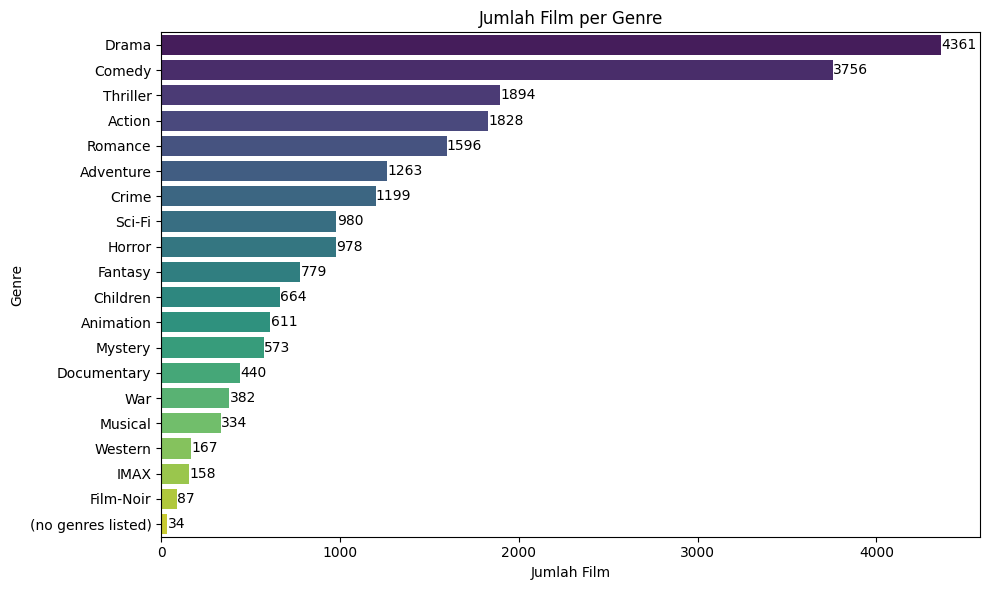

In [ ]:
movies_exploded = movies.assign(genre=movies['genres'].str.split('|')).explode('genre')

genre_counts = movies_exploded['genre'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Jumlah Film per Genre')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
for i, (count) in enumerate(genre_counts.values):
    plt.text(count + 2, i, str(count), va='center')
plt.tight_layout()
plt.show()

Pada kode diatas untuk melihat visualisasi diatas, terlihat bahwa Drama menjadi Genre dengan jumlah film terbanyak pada dataset ini

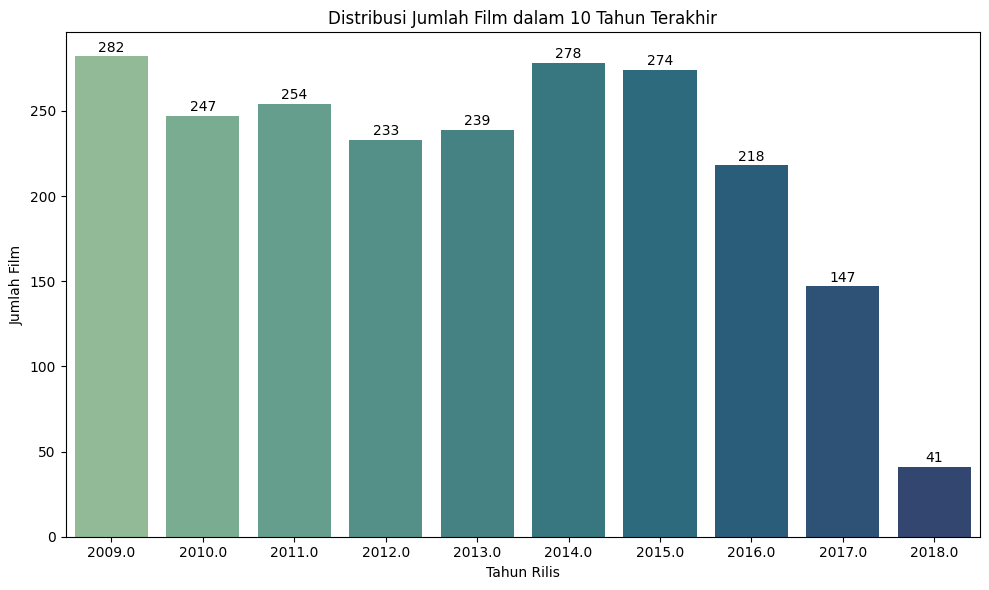

In [ ]:
import re
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        return int(match.group(1))
    return None

movies['year'] = movies['title'].apply(extract_year)

movies = movies.dropna(subset=['year'])

max_year = movies['year'].max()
movies_last_10_years = movies[movies['year'] >= max_year - 9]

year_counts = movies_last_10_years['year'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(x=year_counts.index, y=year_counts.values, palette='crest')
plt.title('Distribusi Jumlah Film dalam 10 Tahun Terakhir')
plt.xlabel('Tahun Rilis')
plt.ylabel('Jumlah Film')
for i, count in enumerate(year_counts.values):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

Pada kode diatas untuk melihat visualisasi distribusi film dalam 10 tahun terakhir dengan terbanyak pada tahun 2009 dengan total 282 film, dan terkecil pada tahun 2018 dengan total 41 film

**Ratings Variabel**

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
print('Jumlah userID: ', len(ratings.userId.unique()))
print('Jumlah movie: ', len(ratings.movieId.unique()))
print('Jumlah data rating: ', len(ratings))

Jumlah userID:  610
Jumlah movie:  9724
Jumlah data rating:  100836


Pada kode diatas untuk melihat informasi terkait dataset rating dengan fungsi `.info()`, melihat data teratas dengan fungsi `.head()`, melihat informasi statistika dataset rating dengan fungsi `.describe()`, dan melihat jumlah data pada dataset tersebut dengan fungsi `.len()`

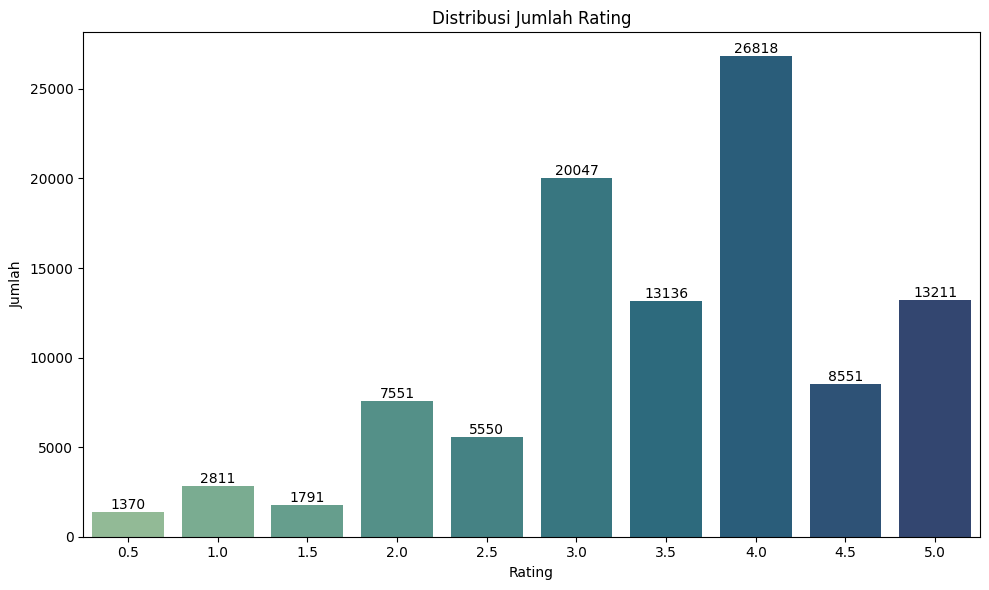

In [ ]:
rating_counts = ratings['rating'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=rating_counts.index.astype(str), y=rating_counts.values, palette='crest')
plt.title('Distribusi Jumlah Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
for i, count in enumerate(rating_counts.values):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

Visualisasi distribusi jumlah rating terbanyak yaitu pada rating 4.0 dengan total 26818 rating, dan jumlah terkecil yaitu pada rating 0,5 dengan total 1370 rating

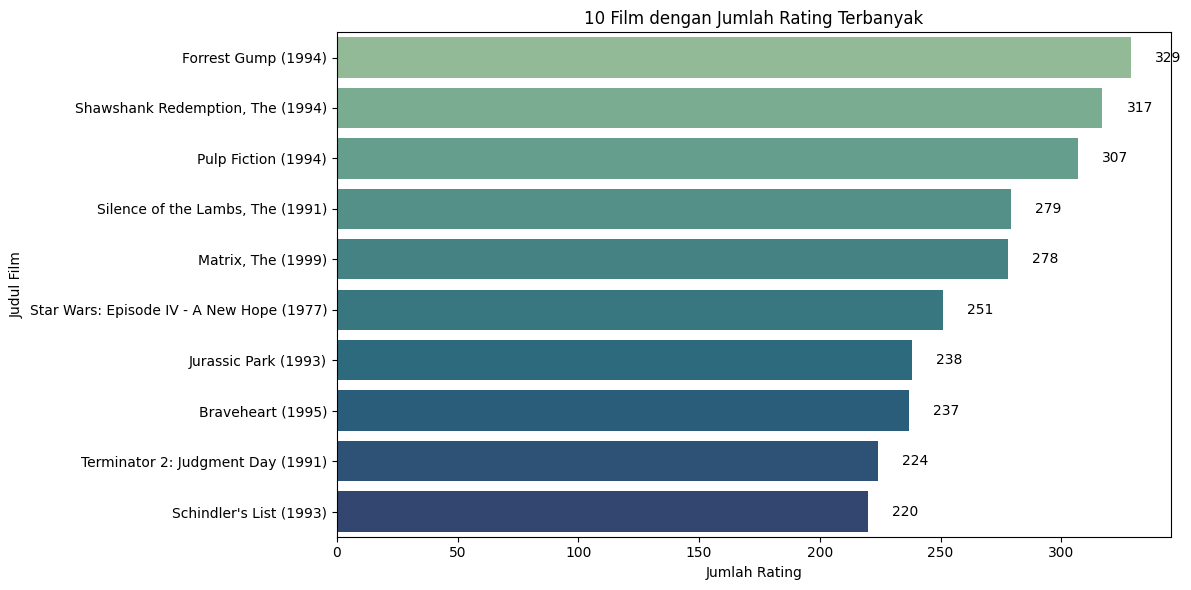

In [ ]:
rating_counts = ratings['movieId'].value_counts().head(10)

# Gabungkan dengan judul film
top_movies = movies[movies['movieId'].isin(rating_counts.index)]
top_movies = top_movies.set_index('movieId').loc[rating_counts.index]
top_movies['rating_count'] = rating_counts.values

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies['rating_count'], y=top_movies['title'], palette='crest')
plt.title('10 Film dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
for i, count in enumerate(top_movies['rating_count']):
    plt.text(count + 10, i, str(count), va='center')
plt.tight_layout()
plt.show()

pada kode tersebut untuk mendapatkan visualisasi 10 film dengan jumlah rating terbanyak, dengan urutan pertama yaitu film forrest gump (1994) dengan 329 rating, dan pada urutan 10 terdapat film schindler's list (1993)

**Data Preparation**

**Content Based Filtering**

In [ ]:
movieid = movies['movieId'].tolist()
movie_title = movies['title'].tolist()
movie_genre = movies['genres'].tolist()

print(len(movieid))
print(len(movie_title))
print(len(movie_genre))

9742
9742
9742


Kode diatas untuk mengubah kolom tertentu menjadi list untuk mempermudah manipulasi dan pencocokan data, antara lain pada kolom `movieId` menjadi `movieid`, `title` menjadi `movie_title`, dan `genres` menjadi `movie_genre` pada dataset movies.

In [ ]:
movie_new = pd.DataFrame({
    'movieId': movieid,
    'movie_title': movie_title,
    'movie_genre': movie_genre
})
movie_new

,movieId,movie_title,movie_genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


selanjutnya membuat dictionary dari list untuk menentukan pasangan key-value pada data `movieid`, `movie_title`, dan `movie_genre` yang telah disiapkan sebelumnya, dengan nama dictionary `movie_new`.

In [ ]:
data = movie_new
data.sample(5)

,movieId,movie_title,movie_genre
5349,8916,Shall We Dance? (2004),Comedy|Romance
2057,2736,Brighton Beach Memoirs (1986),Comedy
233,271,Losing Isaiah (1995),Drama
8911,135456,Ghost in the Shell: Stand Alone Complex - The ...,Action|Animation|Crime|Sci-Fi
7794,92008,Haywire (2011),Action|Thriller


Melihat sebagian data dari dataset besar untuk mempercepat eksplorasi dan pemodelan awal, dengan fungsi `sample(5)` untuk melihat 5 data pertama dari dataset.

**TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data cuisine
tf.fit(data['movie_title'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['00', '000', '007', ..., 'ônibus', 'ôritsu', 'über'], dtype=object)

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data['movie_title'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(9742, 9269)

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.movie_title
).sample(22, axis=1,replace=True).sample(10, axis=0)

,suit,axis,zombie,impossible,critters,its,victor,conforme,lobster,comforts,...,wonderful,mizu,llewyn,enfance,testimone,knuckle,volta,kânibauru,session,crown
movie_title,,,,,,,,,,,,,,,,,,,,,
Enemy at the Gates (2001),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Oscar (1991),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Persuasion (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
What's Eating Gilbert Grape (1993),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dirty Pretty Things (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tomorrowland (2015),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
All the King's Men (2006),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rapid Fire (1992),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Superfast! (2015),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


pada tahap data preparation dengan TF-IDF dilakukan untuk mengubah teks (movie_title atau judul film) menjadi representasi numerik berbobot menggunakan TF-IDF, untuk menangkap pentingnya kata dalam konteks.
Output matriks TF-IDF `(9742, 9269)` yang berarti ada 9742 baris dan 9269 kolom kata unik.

**Cosine Similarity**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.18731077, 0.13388121, ..., 0.        , 0.        ,
        0.        ],
       [0.18731077, 1.        , 0.14702473, ..., 0.        , 0.        ,
        0.        ],
       [0.13388121, 0.14702473, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['movie_title'], columns=data['movie_title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9742, 9742)


movie_title,Ghosts of Mississippi (1996),Patlabor 2: The Movie (1993),Love Story (1970),"Heat, The (2013)",The Nice Guys (2016)
movie_title,,,,,
"Ninth Gate, The (1999)",0.000000,0.029238,0.0,0.036719,0.026904
Mississippi Burning (1988),0.432039,0.000000,0.0,0.000000,0.000000
"Yesterday, Today and Tomorrow (Ieri, oggi, domani) (1963)",0.000000,0.000000,0.0,0.000000,0.000000
Guardians (2016),0.000000,0.000000,0.0,0.000000,0.185551
Darkness Falls (2003),0.000000,0.000000,0.0,0.000000,0.000000
Only You (1994),0.000000,0.000000,0.0,0.000000,0.000000
Red State (2011),0.000000,0.000000,0.0,0.000000,0.000000
"Cannonball Run, The (1981)",0.000000,0.030504,0.0,0.038309,0.028070
"Day the Earth Stood Still, The (2008)",0.000000,0.049145,0.0,0.061720,0.045223


pada tahap cosine similarity yang digunakan untuk menghitung derajat kesamaan (similarity degree) antar film. dan kemudian melihat hasil similarity tabel yang mempunyai kemiripan dengan fungsi `.sample()`

**Mendapatkan Rekomendasi**

In [ ]:
def recommendations(title, similarity_data=cosine_sim_df, items=data[['movie_genre', 'movie_title']], k=10):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Tahap ini untuk mendapatkan rekomendasi film yang paling sesuai dengan film yang telah ditonton, menggunakan 
fungsi `recommendations(title, similarity_data=cosine_sim_df, items=data[['movie_genre', 'movie_title']], k=10)` dengan penjelasan parameter sebagai berikut:
- title : Judul film (index kemiripan dataframe).
- Similarity_data : Dataframe mengenai similarity yang telah  didefinisikan pada tahap cosine similarity yang digunakan untuk menghitung derajat kesamaan (similarity degree) antar film
- Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah `movie_genre` dan `movie_title`.
- k : Banyak rekomendasi yang ingin diberikan.

Mencoba memasukkan nama film dan keluar hasil dengan nama film yang sama

In [ ]:
data[data.movie_title.eq('Toy Story (1995)')]

,movieId,movie_title,movie_genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
recommendations('Toy Story (1995)')

,movie_title,movie_genre
0,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
1,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
2,"Toy, The (1982)",Comedy
3,Toy Soldiers (1991),Action|Drama
4,L.A. Story (1991),Comedy|Romance
5,"Pyromaniac's Love Story, A (1995)",Comedy|Romance
6,Kid's Story (2003),Animation|Sci-Fi
7,"Christmas Story, A (1983)",Children|Comedy
8,Love Story (1970),Drama|Romance
9,True Story (2015),Drama|Mystery|Thriller


**Evaluation**

**Visualisasi Metrik**

In [ ]:
def precision_recall_content_based(input_movie, recommendations, k=10):
    input_tfidf = tf.transform([input_movie])
    rec_tfidf = tf.transform(recommendations)

    sim_scores = cosine_similarity(input_tfidf, rec_tfidf)[0]
    precision = sum(sim_scores[:k]) / k
    recall = sum(sim_scores[:k]) / sum(sim_scores) if sum(sim_scores) > 0 else 0
    return precision * 100, recall * 100

input_movies = ["Toy Story 2 (1999)", "Toy Story 3 (2010)"]
recommendation_results = {data: list(recommendations(data)['movie_title']) for data in input_movies}

for movie in input_movies:
    recommended_titles = recommendation_results[movie]
    precision, recall = precision_recall_content_based(movie, recommended_titles, k=5)
    print(f"Precision@5 for '{movie}': {precision:.2f}%")
    print(f"Recall@5 for '{movie}': {recall:.2f}%")

Precision@5 for 'Toy Story 2 (1999)': 63.75%
Recall@5 for 'Toy Story 2 (1999)': 65.74%
Precision@5 for 'Toy Story 3 (2010)': 62.76%
Recall@5 for 'Toy Story 3 (2010)': 67.86%


**Metrik Evaluasi** yang digunakan adalah Precision@K dan Recall@K, dengan formula sebagai berikut
- Precision@K = `True Positif / Total Rekomended Items`, metrik ini bekerja misalkan sistem merekomendasikan 5 film (K=5) ke pengguna, dan dari kelima film tersebut, 3 film ternyata disukai oleh pengguna (relevan), maka `3/5 = 0,6`, Precision@K berfokus pada akurasi dari top-K rekomendasi. Semakin tinggi nilainya, semakin banyak rekomendasi yang tepat sasaran dari total yang diberikan.
- Recall@K = `True Positif / Total Relevant Items`, metrik ini bekerja misalkan seorang pengguna menyukai 10 film secara keseluruhan, dan dari 5 film yang direkomendasikan (K=5), ada 3 yang memang dia sukai, maka `3/10 = 0,3`, Recall@K berfokus pada kelengkapan: seberapa banyak dari semua item relevan yang berhasil direkomendasikan.
**Interpretasi**
- `Toy Story 2 (1999)` :
    - Precision@5: 63.75% :
        Dari 5 rekomendasi teratas yang diberikan sistem kepada pengguna, sekitar 63.75% di antaranya benar-benar relevan (disukai atau cocok untuk pengguna). Artinya, sistem cukup akurat dalam memilih rekomendasi yang tepat untuk pengguna terkait film ini.
    - Recall@5: 65.74% :
        Dari seluruh film yang seharusnya relevan untuk pengguna (misalnya berdasarkan preferensi atau riwayat mereka), sistem berhasil menemukan dan menyarankan 65.74% di antaranya dalam 5 rekomendasi teratas. Artinya, sistem cukup komprehensif dalam menemukan film yang relevan meskipun hanya memberikan 5 rekomendasi.
- `Toy Story 3 (2010)` :
    - Precision@5: 62.76% :
        Dari 5 film yang direkomendasikan terkait Toy Story 3 (2010), 62.76% di antaranya sesuai dengan selera atau preferensi pengguna. Nilai ini sedikit lebih rendah dibanding Toy Story 2, tapi masih cukup baik.
    - Recall@5: 67.86% :
        Sistem berhasil mencakup 67.86% dari semua film yang seharusnya direkomendasikan kepada pengguna terkait Toy Story 3. Ini menunjukkan sistem agak lebih baik dalam cakupan (recall) dibanding Toy Story 2, walaupun presisinya sedikit lebih rendah.

Dengan evaluasi tersebut, teknik Content Based Filtering sudah bisa memberikan rekomendasi film yang dipersonalisasi untuk pengguna.

**Collaborative Filtering**

In [ ]:
# Import library
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

**Data Preparation**

In [ ]:
df = ratings
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
movie_ids = df['movieId'].unique().tolist()
print('judul movie: ', movie_ids)

# Melakukan encoding userID
judul_to_judul_encoded = {x: i for i, x in enumerate(movie_ids)}
print('encoded judul movie : ', judul_to_judul_encoded)

# Melakukan proses encoding angka ke ke userID
judul_encoded_to_judul = {i: x for i, x in enumerate(movie_ids)}
print('encoded angka ke cluster: ', judul_encoded_to_judul)

judul movie:  [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163, 216, 223, 231, 235, 260, 296, 316, 333, 349, 356, 362, 367, 423, 441, 457, 480, 500, 527, 543, 552, 553, 590, 592, 593, 596, 608, 648, 661, 673, 733, 736, 780, 804, 919, 923, 940, 943, 954, 1009, 1023, 1024, 1025, 1029, 1030, 1031, 1032, 1042, 1049, 1060, 1073, 1080, 1089, 1090, 1092, 1097, 1127, 1136, 1196, 1197, 1198, 1206, 1208, 1210, 1213, 1214, 1219, 1220, 1222, 1224, 1226, 1240, 1256, 1258, 1265, 1270, 1275, 1278, 1282, 1291, 1298, 1348, 1377, 1396, 1408, 1445, 1473, 1500, 1517, 1552, 1573, 1580, 1587, 1617, 1620, 1625, 1644, 1676, 1732, 1777, 1793, 1804, 1805, 1920, 1927, 1954, 1967, 2000, 2005, 2012, 2018, 2028, 2033, 2046, 2048, 2054, 2058, 2078, 2090, 2093, 2094, 2096, 2099, 2105, 2115, 2116, 2137, 2139, 2141, 2143, 2161, 2174, 2193, 2253, 2268, 2273, 2291, 2329, 2338, 2353, 2366, 2387, 2389, 2395, 2406, 2414, 2427, 2450, 2459, 2470, 2478, 2492, 2502, 2528, 2529, 2542, 2571, 2580, 2596, 2616, 2617, 2628, 2640, 2641,

pada kode diatas adalah untuk mengubah ID user dan movieId menjadi angka untuk dapat diproses oleh model.

In [ ]:
# Mapping userID ke dataframe user
df['user'] = df['userId'].map(user_to_user_encoded)

# Mapping movieId ke dataframe judul
df['movie'] = df['movieId'].map(judul_to_judul_encoded)

Tahap tersebut untuk melakukan mapping atau mengganti nilai userID di DataFrame df menjadi nilai numerik (encoded).
Dengan fungsi `.map()`.

In [ ]:
# Mendapatkan jumlah user
num_user = len(user_to_user_encoded)
print(num_user)

num_judul = len(judul_to_judul_encoded)
print(num_judul)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of Track: {}, Number of Title: {}, Min Rating: {}, Max Rating: {}'.format(
    num_user, num_judul, min_rating, max_rating
))

610
9724
Number of Track: 610, Number of Title: 9724, Min Rating: 0.5, Max Rating: 5.0


Pada tahap tersebut cek beberapa hal dalam data seperti jumlah user, jumlah judul film, dan mengubah nilai rating menjadi float. Untuk mengecek jumlah menggunakan fungsi `.len()`, selanjutnya untuk melihat minimal data menggunakan fungsi `.min()`, dan maximal data menggunakan fungsi `.max()` dan untuk mengubah nilai rating menjadi float menggunakan fungsi `.astype(np.float32)`.

**Data Splitting**

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


Pada tahap tersebut kita akan membagi data menjadi 2 bagian yaitu data latih dan validasi untuk evaluasi model yang objektif. Pada proyek ini data dibagi menjadi `80%` untuk `data latih` dan `20%` untuk `data validasi`.

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_user, num_judul, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_user = num_user
    self.num_judul = num_judul
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_user,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_user, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_judul,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_judul, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    judul_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    judul_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_track_judul = tf.tensordot(user_vector, judul_vector, 2)

    x = dot_track_judul + user_bias + judul_bias

    return tf.nn.sigmoid(x) # activation sigmoid


Pada tahap modeling ini menggunakan RecommenderNet (Custom Keras Model) dengan: Embedding layer untuk user dan film. Dot product untuk memprediksi rating. Proses compile pada model dengan binary crossentropy sebagai loss function, adam sebagai optimizer, dan RMSE sebagai metrik dari model.

In [ ]:
model = RecommenderNet(num_user, num_judul, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 30,
    validation_data = (x_val, y_val)
)

Epoch 1/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.6469 - root_mean_squared_error: 0.2418 - val_loss: 0.6130 - val_root_mean_squared_error: 0.2065
Epoch 2/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.6054 - root_mean_squared_error: 0.1989 - val_loss: 0.6092 - val_root_mean_squared_error: 0.2021
Epoch 3/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.6010 - root_mean_squared_error: 0.1931 - val_loss: 0.6083 - val_root_mean_squared_error: 0.2009
Epoch 4/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.5972 - root_mean_squared_error: 0.1906 - val_loss: 0.6077 - val_root_mean_squared_error: 0.2000
Epoch 5/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.5946 - root_mean_squared_error: 0.1876 - val_loss: 0.6073 - val_root_mean_squared_error: 0.1993
Epoch 6/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.5938 - root_mean_squared_error: 0.1856 - val_loss: 0.6069 - val_root_mean_squared_error: 0.1989
Epoch 7/30
10084/10084

**Evaluation**

**Visualisasi Metrik**

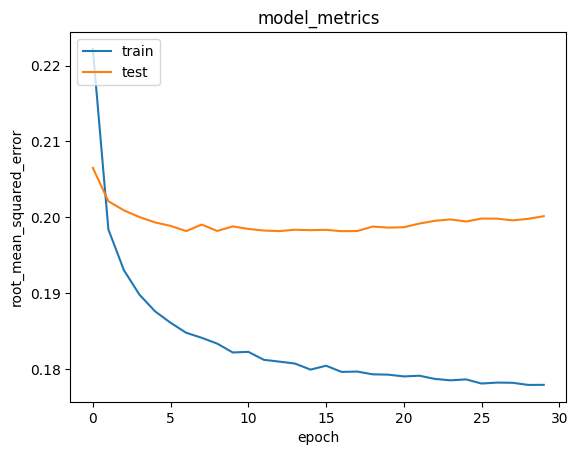

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
movie_df = movie_new
df = pd.read_csv('ratings.csv')

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_not_watched = movie_df[~movie_df['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(judul_to_judul_encoded.keys()))
)

movie_not_watched = [[judul_to_judul_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

In [ ]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    judul_encoded_to_judul.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_title, ':', row.movie_genre)

print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)

recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_title, ':', row.movie_genre)

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Showing recommendations for users: 36
Movie with high ratings from user
--------------------------------
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Waking Ned Devine (a.k.a. Waking Ned) (1998) : Comedy
Never Cry Wolf (1983) : Adventure|Drama
American Graffiti (1973) : Comedy|Drama
Almost Famous (2000) : Drama
--------------------------------
Top 10 movie recommendation
--------------------------------
Antonia's Line (Antonia) (1995) : Comedy|Drama
Heidi Fleiss: Hollywood Madam (1995) : Documentary
Paths of Glory (1957) : Drama|War
Jules and Jim (Jules et Jim) (1961) : Drama|Romance
Guess Who's Coming to Dinner (1967) : Drama
Trial, The (Procès, Le) (1962) : Drama
Adam's Rib (1949) : Comedy|Romance
Tekkonkinkreet (Tekkon kinkurîto) (2006) : Action|Adventure|Animation|Crime|Fantasy
Band of Brothers (2001) : Action|Drama|War
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama


**Metrik Evaluasi** yang digunakan adalah RMSE, metrik RMSE mengukur seberapa jauh prediksi model dari nilai sebenarnya, dengan memberi penalti lebih besar pada kesalahan yang besar. Semakin kecil RMSE, semakin baik performa model.
**Interpretasi Grafik RMSE**
- RMSE pada data train dan test sama-sama turun secara signifikan, menunjukkan bahwa model belajar dengan baik dan memperbaiki kesalahan prediksinya.
- RMSE pada data train terus menurun stabil hingga akhir pelatihan (~0.175), yang berarti model semakin cocok terhadap data pelatihan.
- Nilai akhir RMSE berada pada 0.1774, mengindikasikan error prediksi yang relatif rendah.

Dengan hasil evaluasi tersebut, teknik Collaborative Filtering sudah bisa menyesuaikan preferensi pengguna dan memberikan rekomendasi film yang belum pernah ditonton dengan rating tertinggi.